In [1]:
#!tar -xvf  "C://Users//Prasanta//Downloads//UnivBath//Sem2//Projects//AmazonData//train-jpg.tar" -C "C://Users//Prasanta//Downloads//UnivBath//Sem2//Projects//AmazonData"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil, os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.backend import clear_session
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16
import tensorflow as tf

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.1
EPOCHS = 25
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 5 # No of folds for cross validation
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [5]:
DF_PATH = 'C://Users//Prasanta//Downloads//UnivBath//Sem2//Projects//AmazonData//train-jpg'
DF_CSV_PATH = 'C://Users//Prasanta//Downloads//UnivBath//Sem2//Projects//AmazonData//train_v2.csv//train_v2.csv'
df = pd.read_csv(DF_CSV_PATH)
df['image_name'] = df['image_name'].astype(str) + '.jpg'
#print(df.head())
train, test = train_test_split(df, test_size=0.2, random_state=1)
print(train.head())
print("*****")
print(test.head())

            image_name                 tags
3577    train_3577.jpg         haze primary
10327  train_10327.jpg        clear primary
1243    train_1243.jpg  clear primary water
17066  train_17066.jpg        clear primary
15959  train_15959.jpg        clear primary
*****
            image_name                                   tags
32752  train_32752.jpg                          clear primary
7767    train_7767.jpg                          clear primary
4254    train_4254.jpg  agriculture clear cultivation primary
23119  train_23119.jpg                          clear primary
22101  train_22101.jpg              agriculture clear primary


In [6]:
# def specify_type(fname):
#     if fname in train['image_name'].values:
#         return "train"
#     elif fname in test['image_name'].values:
#         return "test"
    


In [7]:
# dest_folder = "C://Users//Prasanta//Downloads//UnivBath//Sem2//Projects//AmazonData//test-jpg"
# print("******") 
# files = list(test['image_name'])
# for f in files:
#   path = DF_PATH+"/"+f
#   shutil.move(path, dest_folder)
# #print(os.listdir(DF_PATH)) 

In [15]:
dest_folder = "C://Users//Prasanta//Downloads//UnivBath//Sem2//Projects//AmazonData//test-jpg"

In [8]:
X_train_files = np.array(train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(train['tags'].tolist())

In [9]:
labels = []

for tag in train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


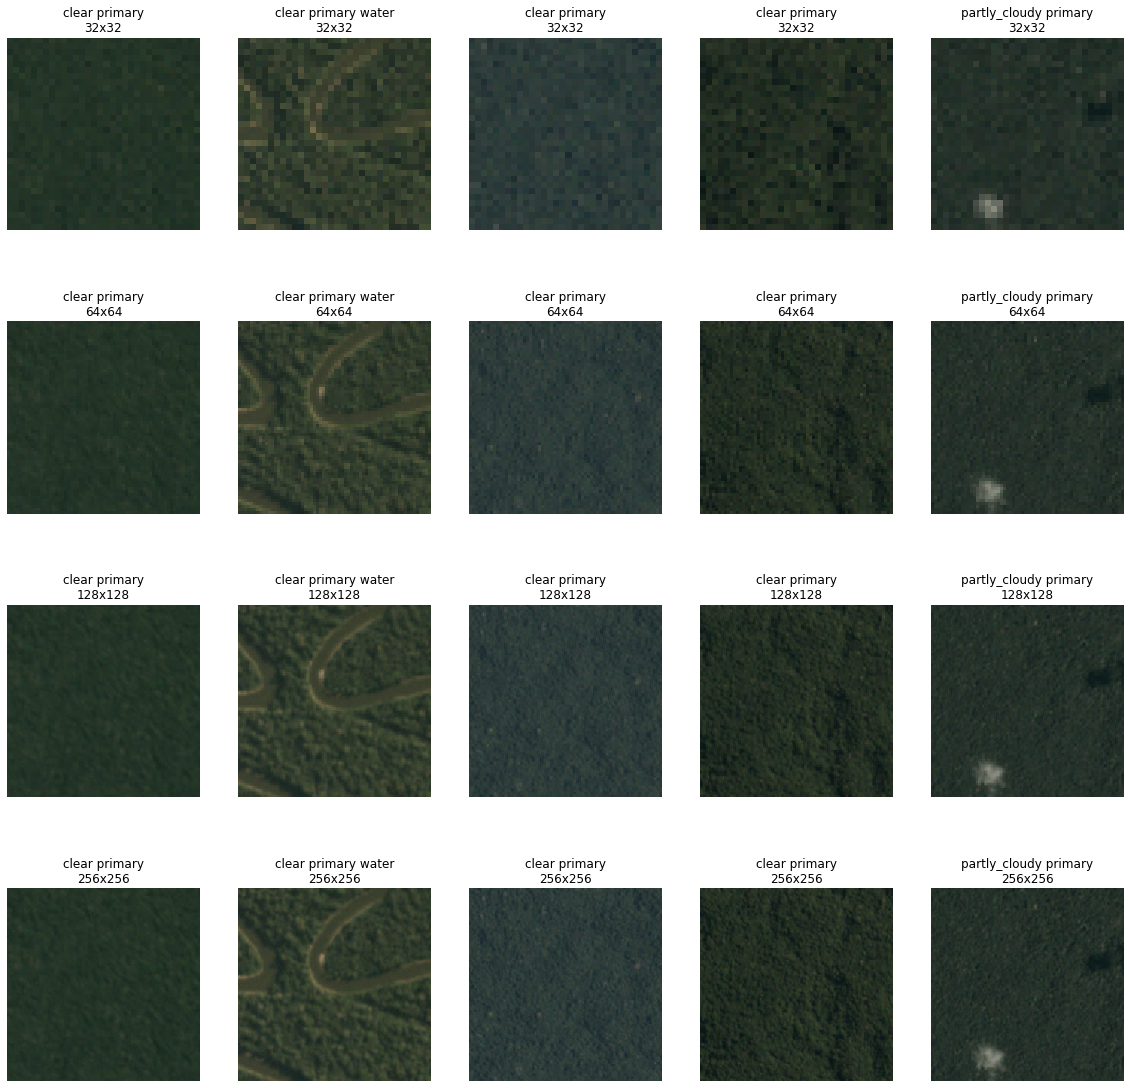

In [10]:
plt.figure(figsize=(20, 20))
res = [32, 64, 128, 256]
NIMGS = 5
train = train.reset_index()
test = test.reset_index()

for i in range(len(res)):
    for j in range(NIMGS):
        img = cv2.imread(os.path.join(DF_PATH, train['image_name'][j+1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]))
        plt.axis('off')
    
plt.show()

blow_down is tagged least no of times: 74
primary is tagged max no of times: 29978


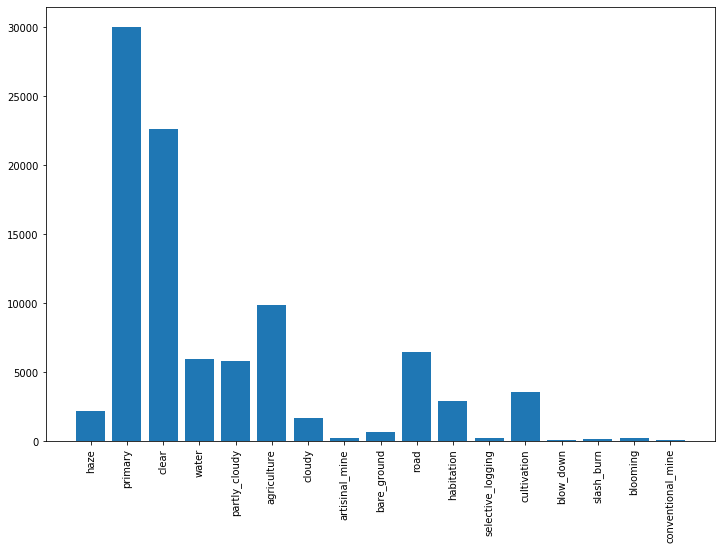

In [11]:
#Distribution of the labels :

plt.figure(figsize=(12, 8))

labels_count = {}

for tag in train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [12]:
# Define learning curve and evaluation metric (f-2 Beta score):

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [13]:
#Define CNN model architecture:

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Flatten(),

#         Dense(1024, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])

#     optimizer = SGD(lr=0.01, momentum=0.9)   # try 1 iteration with adam
    optimizer = Adam(0.001, decay=0.0001)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score_K])
    return model

model = create_model()

# model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[fbeta_score_K])
clear_session()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [ ]:
#Run the model  with k-fold cross validation:

EPOCHS = 5

y_test = []

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)
num_fold = 0
for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=DF_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=DF_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        test,
        directory=dest_folder,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='fbeta_score_K', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                       workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
    y_test.append(p_test)
    num_fold+=1

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 382 validated image filenames belonging to 17 classes.
Epoch 1/5
203/203 [==============================] - 5476s 27s/step - loss: 0.2843 - fbeta_score_K: 0.5390 - val_loss: 0.2432 - val_fbeta_score_K: 0.5763
Epoch 2/5
203/203 [==============================] - 3802s 19s/step - loss: 0.2189 - fbeta_score_K: 0.6098 - val_loss: 0.1962 - val_fbeta_score_K: 0.5927
Epoch 3/5
203/203 [==============================] - 4010s 20s/step - loss: 0.2080 - fbeta_score_K: 0.6319 - val_loss: 0.1978 - val_fbeta_score_K: 0.6299
Epoch 4/5
203/203 [==============================] - 4833s 24s/step - loss: 0.1974 - fbeta_score_K: 0.6512 - val_loss: 0.1760 - val_fbeta_score_K: 0.6510
Epoch 5/5
203/203 [==============================] - 4538s 22s/step - loss: 0.1844 - fbeta_score_K: 0.6763 - val_loss: 0.1771 - val_fbeta_score_K: 0.6738
Found 25906 validated image filenames belong